<a href="https://colab.research.google.com/github/jellyXuuuuu/CovidNetDeepLearning/blob/main/sample_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !cp 'drive/MyDrive/covid/requirements.txt' .

In [2]:
# !pip3 install -r requirements.txt

In [3]:
!pip3 install python-gdcm
!pip3 install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!pip install tensorflow==1.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92.6 MB 1.4 MB/s 
     |████████████████████████████████| 367 kB 46.1 MB/s 
     |████████████████████████████████| 50 kB 6.8 MB/s 
     |████████████████████████████████| 3.2 MB 22.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

In [ ]:
import tensorflow as tf
print( tf.__version__ )

In [5]:
import os
import cv2
import glob
import pydicom
# import dicom
from pydicom.pixel_data_handlers import apply_modality_lut, apply_voi_lut
import numpy as np
import pandas as pd

In [2]:
# data.py
import tensorflow as tf
from tensorflow import keras

from functools import partial
import numpy as np
import os
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]

def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv2.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv2.resize(img, (size, size))
    return img

def process_image_file_medusa(filepath, size):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    img = img.astype('float64')
    img -= img.mean()
    img /= img.std()
    return np.expand_dims(img, -1)

def random_ratio_resize(img, prob=0.3, delta=0.1):
    if np.random.rand() >= prob:
        return img
    ratio = img.shape[0] / img.shape[1]
    ratio = np.random.uniform(max(ratio - delta, 0.01), ratio + delta)

    if ratio * img.shape[1] <= img.shape[1]:
        size = (int(img.shape[1] * ratio), img.shape[1])
    else:
        size = (img.shape[0], int(img.shape[0] / ratio))

    dh = img.shape[0] - size[1]
    top, bot = dh // 2, dh - dh // 2
    dw = img.shape[1] - size[0]
    left, right = dw // 2, dw - dw // 2

    if size[0] > 480 or size[1] > 480:
        print(img.shape, size, ratio)

    img = cv2.resize(img, size)
    img = cv2.copyMakeBorder(img, top, bot, left, right, cv2.BORDER_CONSTANT,
                             (0, 0, 0))

    if img.shape[0] != 480 or img.shape[1] != 480:
        raise ValueError(img.shape, size)
    return img

_augmentation_transform = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.9, 1.1),
    zoom_range=(0.85, 1.15),
    fill_mode='constant',
    cval=0.,
)

def apply_augmentation(img):
    img = random_ratio_resize(img)
    img = _augmentation_transform.random_transform(img)
    return img

def _process_csv_file(file):
    with open(file, 'r') as fr:
        files = fr.readlines()
    return files


class BalanceCovidDataset(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(
            self,
            data_dir,
            csv_file,
            is_training=True,
            batch_size=8,
            medusa_input_shape=(256, 256),
            input_shape=(480, 480),
            n_classes=2,
            num_channels=3,
            mapping={
                'negative': 0,
                'positive': 1,
            },
            shuffle=True,
            augmentation=apply_augmentation,
            covid_percent=0.5,
            class_weights=[1., 1.],
            top_percent=0.08,
            is_severity_model=False,
            is_medusa_backbone=False,
    ):
        'Initialization'
        self.datadir = data_dir
        self.dataset = _process_csv_file(csv_file)
        self.is_training = is_training
        self.batch_size = batch_size
        self.N = len(self.dataset)
        self.medusa_input_shape = medusa_input_shape
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.num_channels = num_channels
        self.mapping = mapping
        self.shuffle = shuffle
        self.covid_percent = covid_percent
        self.class_weights = class_weights
        self.n = 0
        self.augmentation = augmentation
        self.top_percent = top_percent
        self.is_severity_model = is_severity_model
        self.is_medusa_backbone = is_medusa_backbone

        # If using MEDUSA backbone load images without crop
        if self.is_medusa_backbone:
            self.load_image = partial(process_image_file, top_percent=0, crop=False)
        else:
            self.load_image = process_image_file

        datasets = {}
        for key in self.mapping.keys():
            datasets[key] = []

        for l in self.dataset:
            datasets[l.split()[2]].append(l)
        
        if self.is_severity_model:
            self.datasets = [
                datasets['level2'], datasets['level1']
            ]
        elif self.n_classes == 2:
            self.datasets = [
                datasets['negative'], datasets['positive']
            ]
        elif self.n_classes == 3:
            self.datasets = [
                datasets['normal'] + datasets['pneumonia'],
                datasets['COVID-19'],
            ]
        else:
            raise Exception('Only binary or 3 class classification currently supported.')
        print(len(self.datasets[0]), len(self.datasets[1]))

        self.on_epoch_end()

    def __next__(self):
        # Get one batch of data
        model_inputs = self.__getitem__(self.n)
        # Batch index
        self.n += 1

        # If we have processed the entire dataset then
        if self.n >= self.__len__():
            self.on_epoch_end()
            self.n = 0

        return model_inputs

    def __len__(self):
        return int(np.ceil(len(self.datasets[0]) / float(self.batch_size)))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            for v in self.datasets:
                np.random.shuffle(v)

    def __getitem__(self, idx):
        batch_x = np.zeros((self.batch_size, *self.input_shape, self.num_channels))
        batch_y = np.zeros(self.batch_size)

        if self.is_medusa_backbone:
            batch_sem_x = np.zeros((self.batch_size, *self.medusa_input_shape, 1))

        batch_files = self.datasets[0][idx * self.batch_size:(idx + 1) * self.batch_size]

        # upsample covid cases
        covid_size = max(int(len(batch_files) * self.covid_percent), 1)
        covid_inds = np.random.choice(np.arange(len(batch_files)),
                                      size=covid_size,
                                      replace=False)
        covid_files = np.random.choice(self.datasets[1],
                                       size=covid_size,
                                       replace=False)
        for i in range(covid_size):
            batch_files[covid_inds[i]] = covid_files[i]

        for i in range(len(batch_files)):
            sample = batch_files[i].split()

            if self.is_training:
                folder = 'train'
            else:
                folder = 'test'

            image_file = os.path.join(self.datadir, folder, sample[1])
            x = self.load_image(
                image_file,
                self.input_shape[0],
                top_percent=self.top_percent,
            )

            if self.is_training and hasattr(self, 'augmentation'):
                x = self.augmentation(x)

            x = x.astype('float32') / 255.0

            if self.is_medusa_backbone:
                sem_x = process_image_file_medusa(image_file, self.medusa_input_shape[0])
                batch_sem_x[i] = sem_x
            
            y = self.mapping[sample[2]]

            batch_x[i] = x
            batch_y[i] = y

        class_weights = self.class_weights
        weights = np.take(class_weights, batch_y.astype('int64'))
        batch_y = keras.utils.to_categorical(batch_y, num_classes=self.n_classes)

        if self.is_medusa_backbone:
            return batch_sem_x, batch_x, batch_y, weights, self.is_training
        else:
            return batch_x, batch_y, weights, self.is_training
        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
!cp -r 'drive/MyDrive/covid/labels/' .

In [3]:
!cp -r 'drive/MyDrive/covid/models/' .

In [9]:
# copy test image file
!cp -r 'drive/MyDrive/data' .
!cp 'drive/MyDrive/covid/testimage/0a8d486f-1aa6-4fcf-b7be-4bf04fc8628b.png' './data/test'

In [4]:
!cp -r 'drive/MyDrive/covid/assets/' .

# Inference

In [3]:
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
import os, argparse

# To remove TF Warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


if __name__ == '__main__':
    # args = []
    '''
    python inference.py \
    --weightspath models/COVIDNet-CXR-2 \
    --metaname model.meta \
    --ckptname model \
    --n_classes 2 \
    --imagepath assets/ex-covid.jpeg \
    --in_tensorname input_1:0 \
    --out_tensorname norm_dense_2/Softmax:0

    python inference.py \
    --weightspath models/COVIDNet-CXR-3 \
    --metaname model.meta \
    --ckptname model \
    --n_classes 2 \
    --imagepath assets/ex-covid.jpeg \
    --out_tensorname softmax/Softmax:0 \
    --is_medusa_backbone

    '''

    # USE COVIDNet CXR 2

    args_weightspath = 'models/COVIDNet-CXR-2' 
    args_metaname = 'model.meta'
    args_ckptname = 'model'
    args_n_classes = 2

    args_testfolder = 'data/test'
    args_trainfile = 'labels/train_COVIDx9B.txt'
    args_testfile = 'labels/test_COVIDx9B.txt'

    args_out_tensorname = 'norm_dense_2/Softmax:0'
    args_logit_tensorname = 'norm_dense_2/MatMul:0'
    args_is_severity_model = False
    args_is_medusa_backbone = False

    args_in_tensorname = 'input_1:0'
    args_in_tensorname_medusa = 'input_1:0'
    args_input_size = 480
    args_input_size_medusa = 256
    args_top_percent = 0.08
    
    '''
    <<<<<<<<<<<<<<<<<<Here to change the test image!!! >>>>>>>>>>>>>>>>>>>>
    '''

    args_imagepath = 'assets/ex-covid.jpeg'
    # args_imagepath = "data/test/0a8d486f-1aa6-4fcf-b7be-4bf04fc8628b.png"
    # args_imagepath = "drive/MyDrive/covid/ricord_images/MIDRC-RICORD-1C-SITE2-000293-40361-0.png"
    
    sess = tf.compat.v1.Session()
    # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    # tf.compat.v1.keras.backend.set_session(sess)

    

    if args_is_severity_model:
        # For COVIDNet CXR-S training with COVIDxSev level 1 and level 2 air space seveirty grading
        mapping = {'level2': 0, 'level1': 1}
        inv_mapping = {0: 'level2', 1: 'level1'}
    elif args_n_classes == 2:
        # For COVID-19 positive/negative detection
        mapping = {'negative': 0, 'positive': 1}
        inv_mapping = {0: 'negative', 1: 'positive'}
    elif args_n_classes == 3:
        # For detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia
        mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
        inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}
    else:
        raise Exception('''COVID-Net currently only supports 2 class COVID-19 positive/negative detection
            or 3 class detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia''')

    print("mapping", mapping)
    mapping_keys = list(mapping.keys())

    # tf.get_default_graph()
    # tf.compat.v1.get_default_graph()
    # saver = tf.compat.v1.train.import_meta_graph(os.path.join(args_weightspath, args_metaname))
    # saver.restore(sess, os.path.join(args_weightspath, args_ckptname))

    # graph = tf.get_default_graph()

    # image_tensor = graph.get_tensor_by_name(args_in_tensorname)
    # pred_tensor = graph.get_tensor_by_name(args_out_tensorname)
    
    sess = tf.Session()
    tf.get_default_graph()
    saver = tf.train.import_meta_graph(os.path.join(args_weightspath, args_metaname))
    saver.restore(sess, os.path.join(args_weightspath, args_ckptname))

    graph = tf.get_default_graph()

    image_tensor = graph.get_tensor_by_name(args_in_tensorname)
    pred_tensor = graph.get_tensor_by_name(args_out_tensorname)



    # print("GRAPH: -------------------")
    # for op in graph.get_operations():
    #   print(op.name)


    # //////////////////////////////////


    # y_test = []
    # pred = []

    # # for i in range(len(testfile)):
    # # line = testfile[0].split()
    # lines = "0a8d486f-1aa6-4fcf-b7be-4bf04fc8628b 0a8d486f-1aa6-4fcf-b7be-4bf04fc8628b.png negative rsna"
    # line = lines.split()
    # image_file = os.path.join(args_testfolder, line[1])
    # # image_file = os.path.join(args_testfolder, "0a8d486f-1aa6-4fcf-b7be-4bf04fc8628b.png")  #0a8d486f-1aa6-4fcf-b7be-4bf04fc8628b
    
    # '''
    # 0a8d486f-1aa6-4fcf-b7be-4bf04fc8628b 0a8d486f-1aa6-4fcf-b7be-4bf04fc8628b.png negative rsna
    # '''

    # print("testfolder line1, image", image_file)
    
    # y_test.append(mapping[line[2]])

    # x = process_image_file(image_file, args_input_size, top_percent=0.08)
    # x = x.astype('float32') / 255.0
    # data_tensor = tf.get_default_graph().get_tensor_by_name("input_1:0")  # /////////////////////????input_2:0
    # feed_dict = {data_tensor: np.expand_dims(x, axis=0)}

    # # print("Not is_medusa_backbone")

    # \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

    if args_is_medusa_backbone:
        x = process_image_file(args_imagepath, args_input_size, top_percent=0, crop=False)
        x = x.astype('float32') / 255.0
        medusa_image_tensor = graph.get_tensor_by_name(args_in_tensorname_medusa)
        medusa_x = process_image_file_medusa(args_imagepath, args_input_size_medusa)
        feed_dict = {
                    medusa_image_tensor: np.expand_dims(medusa_x, axis=0),
                    image_tensor: np.expand_dims(x, axis=0),
                } 
    else:
        x = process_image_file(args_imagepath, args_input_size, top_percent=args_top_percent)
        x = x.astype('float32') / 255.0
        feed_dict = {image_tensor: np.expand_dims(x, axis=0)}

   

    print("feed_dict", feed_dict)
    
    
    pred = sess.run(pred_tensor, feed_dict=feed_dict)
    
    # pred.append(np.array(sess.run(args_out_tensorname, feed_dict=feed_dict)).argmax(axis=1))  ############
    # print("sess_run", sess.run(args_out_tensorname, feed_dict=feed_dict))
    # print("np", np.array(sess.run(args_out_tensorname, feed_dict=feed_dict))) # [[9.9999774e-01 2.2671331e-06]]
    
    # print("argmax", np.array(sess.run(args_out_tensorname, feed_dict=feed_dict)).argmax(axis=1))
    # print("pred[0]", pred[0])  # index of the maximum, in this case, the first arg is bigger than the second
    
    
    # y_test = np.array(y_test)
    # pred = np.array(pred)

    # print_metrics(y_test, pred, mapping)

    print("pred", pred)

    print('Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
    print('Confidence')
    print(' '.join('{}: {:.3f}'.format(cls.capitalize(), pred[0][i]) for cls, i in mapping.items()))
    print('**DISCLAIMER**')
    print('Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.')




mapping {'negative': 0, 'positive': 1}
feed_dict {<tf.Tensor 'input_1:0' shape=(?, 480, 480, 3) dtype=float32>: array([[[[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.3764706 , 0.3764706 , 0.3764706 ],
         [0.34509805, 0.34509805, 0.34509805],
         [0.33333334, 0.33333334, 0.33333334]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.35686275, 0.35686275, 0.35686275],
         [0.3529412 , 0.3529412 , 0.3529412 ],
         [0.3529412 , 0.3529412 , 0.3529412 ]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.        , 0.        , 0.        ],
         ...,
         [0.3529412 , 0.3529412 , 0.3529412 ],
         [0.34901962, 0.34901962, 0.34901962],
         [0.3529412 , 0.3529412 , 0.3529412

# Add Grad Cam

In [7]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.8 MB 3.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=924ed88599f9d7f5765c883b4eb3590f8e4a18e9bf292bbc58518dc10a73ac08
  Stored in directory: /root/.cache/pip/wheels/a4/6a/11/fa213a7aaae1a99a800b86bdd1cc95bc9c7d7914b0859663b8
Successfully built grad-cam


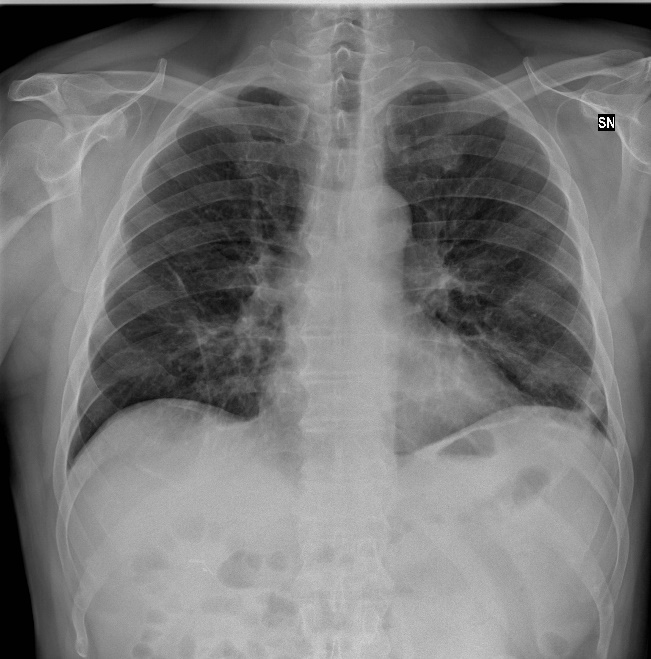

In [4]:
# grad cam
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
# img_path = keras.utils.get_file(
#     "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
# )

# imagepath = 'assets/ex-covid.jpeg'
imagepath = args_imagepath
# MIDRC-RICORD-1C-SITE2-000293-40361-0
display(Image(imagepath))




## Grad Cam Algo

In [5]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# # Prepare image
# img_array = preprocess_input(get_img_array(imagepath, size=img_size))
# print(img_array)

# # Make model
# model = model_builder(weights="imagenet")

# # Remove last layer's softmax
# model.layers[-1].activation = None

# # Print what the top predicted class is
# preds = model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# # Generate class activation heatmap
# heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# # Display heatmap
# plt.matshow(heatmap)
# plt.show()

In [ ]:
# def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
#     # Load the original image
#     img = keras.preprocessing.image.load_img(img_path)
#     img = keras.preprocessing.image.img_to_array(img)

#     # Rescale heatmap to a range 0-255
#     heatmap = np.uint8(255 * heatmap)

#     # Use jet colormap to colorize heatmap
#     jet = cm.get_cmap("jet")

#     # Use RGB values of the colormap
#     jet_colors = jet(np.arange(256))[:, :3]
#     jet_heatmap = jet_colors[heatmap]

#     # Create an image with RGB colorized heatmap
#     jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
#     jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
#     jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

#     # Superimpose the heatmap on original image
#     superimposed_img = jet_heatmap * alpha + img
#     superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

#     # Save the superimposed image
#     superimposed_img.save(cam_path)

#     # Display Grad CAM
#     display(Image(cam_path))


# save_and_display_gradcam(img_path, heatmap)

In [ ]:
# from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image
# from torchvision.models import resnet50

# parser = argparse.ArgumentParser()
# parser.add_argument('--use-cuda', action='store_true', default=False,
#                         help='Use NVIDIA GPU acceleration')
# args = parser.parse_args(args = [])

# model = resnet50(pretrained=True)
# target_layers = [model.layer4[-1]]
# input_tensor = Image(imagepath)  # Create an input tensor image for your model..
# # Note: input_tensor can be a batch tensor with several images!

# # Construct the CAM object once, and then re-use it on many images:
# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda)

# # You can also use it within a with statement, to make sure it is freed,
# # In case you need to re-create it inside an outer loop:
# # with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
# #   ...

# # We have to specify the target we want to generate
# # the Class Activation Maps for.
# # If targets is None, the highest scoring category
# # will be used for every image in the batch.
# # Here we use ClassifierOutputTarget, but you can define your own custom targets
# # That are, for example, combinations of categories, or specific outputs in a non standard model.

# targets = [ClassifierOutputTarget(281)]

# # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# # In this example grayscale_cam has only one image in the batch:
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

In [ ]:
# python cam.py --image-path <path_to_image> --method <method>

## From cam.py

In [8]:
import argparse
import cv2
import numpy as np
import torch
from torchvision import models
from pytorch_grad_cam import GradCAM, \
    HiResCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad, \
    GradCAMElementWise


from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--use-cuda', action='store_true', default=False,
                        help='Use NVIDIA GPU acceleration')
    parser.add_argument(
        '--image-path',
        type=str,
        default='./examples/both.png',
        help='Input image path')
    parser.add_argument('--aug_smooth', action='store_true',
                        help='Apply test time augmentation to smooth the CAM')
    parser.add_argument(
        '--eigen_smooth',
        action='store_true',
        help='Reduce noise by taking the first principle componenet'
        'of cam_weights*activations')
    parser.add_argument('--method', type=str, default='gradcam',
                        choices=['gradcam', 'hirescam', 'gradcam++',
                                 'scorecam', 'xgradcam',
                                 'ablationcam', 'eigencam',
                                 'eigengradcam', 'layercam', 'fullgrad'],
                        help='Can be gradcam/gradcam++/scorecam/xgradcam'
                             '/ablationcam/eigencam/eigengradcam/layercam')

    args = parser.parse_args()
    args.use_cuda = args.use_cuda and torch.cuda.is_available()
    if args.use_cuda:
        print('Using GPU for acceleration')
    else:
        print('Using CPU for computation')

    return args



In [ ]:
!cp -r "drive/MyDrive/covid/ricord_images/" .

In [9]:
if __name__ == '__main__':
    """ python cam.py -image-path <path_to_image>
    Example usage of loading an image, and computing:
        1. CAM
        2. Guided Back Propagation
        3. Combining both
    """
    parser = argparse.ArgumentParser()
    args = parser.parse_args(args = [])

    args.image_path = './assets/ex-covid.jpeg'
    # args.image_path = "./ricord_images/MIDRC-RICORD-1C-SITE2-000293-40361-0.png"
    args.method = "gradcam"
    args.use_cuda = False
    args.aug_smooth = True
    args.eigen_smooth = True

    methods = \
        {"gradcam": GradCAM,
         "hirescam": HiResCAM,
         "scorecam": ScoreCAM,
         "gradcam++": GradCAMPlusPlus,
         "ablationcam": AblationCAM,
         "xgradcam": XGradCAM,
         "eigencam": EigenCAM,
         "eigengradcam": EigenGradCAM,
         "layercam": LayerCAM,
         "fullgrad": FullGrad,
         "gradcamelementwise": GradCAMElementWise}

    model = models.resnet50(pretrained=True)

    # Choose the target layer you want to compute the visualization for.
    # Usually this will be the last convolutional layer in the model.
    # Some common choices can be:
    # Resnet18 and 50: model.layer4
    # VGG, densenet161: model.features[-1]
    # mnasnet1_0: model.layers[-1]
    # You can print the model to help chose the layer
    # You can pass a list with several target layers,
    # in that case the CAMs will be computed per layer and then aggregated.
    # You can also try selecting all layers of a certain type, with e.g:
    # from pytorch_grad_cam.utils.find_layers import find_layer_types_recursive
    # find_layer_types_recursive(model, [torch.nn.ReLU])
    target_layers = [model.layer4]

    rgb_img = cv2.imread(args.image_path, 1)[:, :, ::-1]
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

    # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category (for every member in the batch) will be used.
    # You can target specific categories by
    # targets = [e.g ClassifierOutputTarget(281)]
    targets = None

    # Using the with statement ensures the context is freed, and you can
    # recreate different CAM objects in a loop.
    cam_algorithm = methods[args.method]
    with cam_algorithm(model=model,
                       target_layers=target_layers,
                       use_cuda=args.use_cuda) as cam:

        # AblationCAM and ScoreCAM have batched implementations.
        # You can override the internal batch size for faster computation.
        cam.batch_size = 32
        grayscale_cam = cam(input_tensor=input_tensor,
                            targets=targets,
                            aug_smooth=args.aug_smooth,
                            eigen_smooth=args.eigen_smooth)

        # Here grayscale_cam has only one image in the batch
        grayscale_cam = grayscale_cam[0, :]

        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
        cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=args.use_cuda)
    gb = gb_model(input_tensor, target_category=None)

    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_gb = deprocess_image(cam_mask * gb)
    gb = deprocess_image(gb)

    cv2.imwrite(f'{args.method}_cam2.jpg', cam_image)
    cv2.imwrite(f'{args.method}_gb2.jpg', gb)
    cv2.imwrite(f'{args.method}_cam_gb2.jpg', cam_gb)
    

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [14]:
from google.colab.patches import cv2_imshow

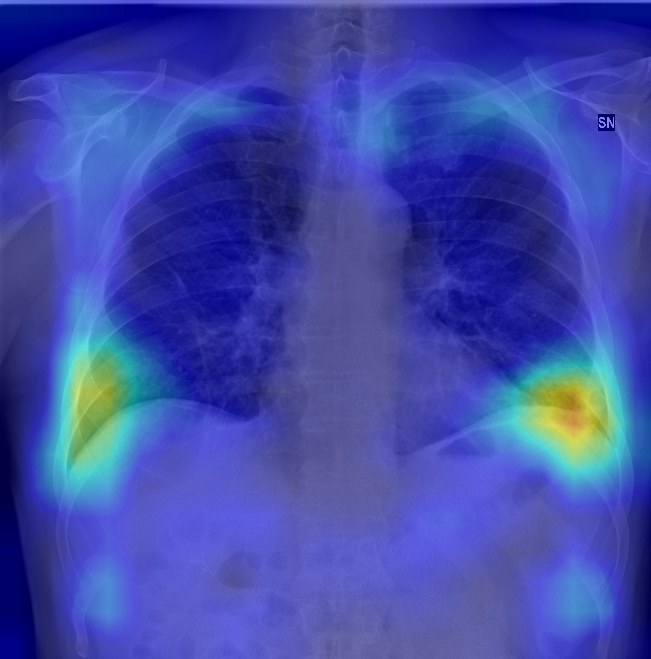

In [15]:
cv2_imshow(cam_image)

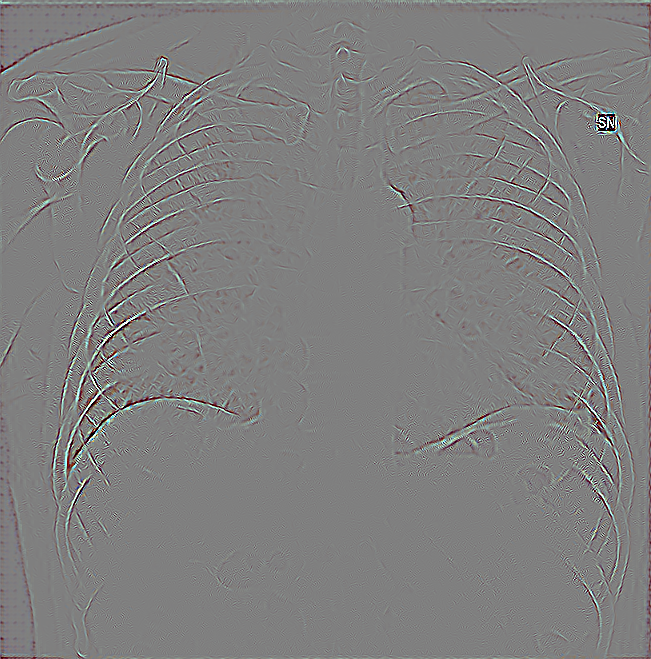

In [16]:
cv2_imshow(gb)

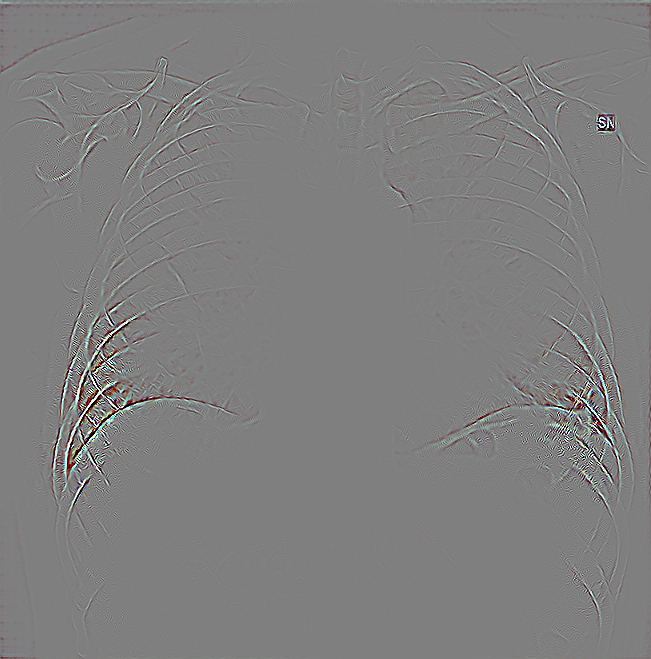

In [17]:
cv2_imshow(cam_gb)